In [80]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import os

In [96]:
labels = ["Coleoptera", "Diptera", "Hemiptera", "Hymenoptera", "Lepidoptera", "Odonata"]


### Reading the tf record files

In [81]:
tf_records_path = os.path.join(os.getcwd(), "dataset/records")
tf_records = [os.path.join(tf_records_path, path) for path in os.listdir(tf_records_path)]
print(f"found {len(tf_records)} tf records files")

found 68 tf records files


In [91]:
image_feature_description = {
    "image/height" :  tf.io.FixedLenFeature([], tf.int64),
    "image/width" : tf.io.FixedLenFeature([], tf.int64),
    "image/encoded" : tf.io.FixedLenFeature([], tf.string),
    "image/obj/heights": tf.io.VarLenFeature(tf.int64),
    "image/obj/widths": tf.io.VarLenFeature(tf.int64),
    "image/obj/lefts": tf.io.VarLenFeature(tf.int64),
    "image/obj/tops": tf.io.VarLenFeature(tf.int64),
    "image/obj/class_id": tf.io.VarLenFeature(tf.int64)
}



def parse_function(example_proto): 
    """
        deserialize a raw record
    """
    example =  tf.io.parse_single_example(example_proto, image_feature_description)
    width = example["image/width"] 
    height = example["image/height"]
    image = tf.image.decode_image(example["image/encoded"], channels=3)
    image = tf.cast(image, dtype=tf.float32) / 255.0
    bboxes = tf.stack([
         tf.sparse.to_dense(example["image/obj/heights"] / height), 
         tf.sparse.to_dense(example["image/obj/widths"] / width), 
         tf.sparse.to_dense(example["image/obj/lefts"] / width), 
         tf.sparse.to_dense(example["image/obj/tops"] / height)
    ], axis=1)
    
    label = tf.stack(tf.sparse.to_dense(example["image/obj/class_id"]))
    
    return image, bboxes, label
    

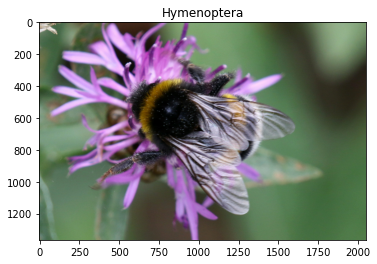

In [98]:
# opening the raw dataset out of the tf records files
raw_dataset = tf.data.TFRecordDataset(tf_records)
raw_dataset = raw_dataset.map(parse_function)
for sample in raw_dataset.take(1): 
    img = sample[0] 
    label = np.squeeze(sample[2])
    label = labels[label]
    plt.title(label)
    plt.imshow(img)